In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from resnet1d import Res34SimSiam, Res34SimSiamSplitHeads, Resnet34Baseline
from dataset import Dataset_per_file, Dataset_whole, Dataset_ori
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
from torch.autograd import Variable
import os
import numpy as np
from tqdm import tqdm
import argparse
import random
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_recall_curve, auc
import sys
import os

from collections import OrderedDict
import pickle as pkl
import matplotlib.pyplot as plt
import wfdb

In [2]:
MODEL_PATH = '/home/zguo30/ppg_ecg_proj/simsiam/saved_models/corrected_resnet_34_epoch_30_ecglr_0.0001_ppglr_0.0001_lambda_1.0_dim1_512_dim2_128_pred_True_bs=5000/model_1.pt'

# BUT-PDB

In [11]:
pwave_data_path = '/labs/hulab/stark_stuff/physionet.org/files/but-pdb/1.0.0/'
!ls '/labs/hulab/stark_stuff/physionet.org/files/but-pdb/1.0.0/'

01.dat	  08.pwave  16.dat    23.pwave	31.dat	  38.pwave  46.dat
01.hea	  08.qrs    16.hea    23.qrs	31.hea	  38.qrs    46.hea
01.pwave  09.dat    16.pwave  24.dat	31.pwave  39.dat    46.pwave
01.qrs	  09.hea    16.qrs    24.hea	31.qrs	  39.hea    46.qrs
02.dat	  09.pwave  17.dat    24.pwave	32.dat	  39.pwave  47.dat
02.hea	  09.qrs    17.hea    24.qrs	32.hea	  39.qrs    47.hea
02.pwave  10.dat    17.pwave  25.dat	32.pwave  40.dat    47.pwave
02.qrs	  10.hea    17.qrs    25.hea	32.qrs	  40.hea    47.qrs
03.dat	  10.pwave  18.dat    25.pwave	33.dat	  40.pwave  48.dat
03.hea	  10.qrs    18.hea    25.qrs	33.hea	  40.qrs    48.hea
03.pwave  11.dat    18.pwave  26.dat	33.pwave  41.dat    48.pwave
03.qrs	  11.hea    18.qrs    26.hea	33.qrs	  41.hea    48.qrs
04.dat	  11.pwave  19.dat    26.pwave	34.dat	  41.pwave  49.dat
04.hea	  11.qrs    19.hea    26.qrs	34.hea	  41.qrs    49.hea
04.pwave  12.dat    19.pwave  27.dat	34.pwave  42.dat    49.pwave
04.qrs	  12.hea    19.qrs    27.hea	34.qrs	  4

In [54]:
a = '16'
tmp = wfdb.rdrecord(f'{pwave_data_path}/{a}') 
tmpannpwave = wfdb.rdann(f'{pwave_data_path}/{a}', 'pwave') 
tmpannqrs = wfdb.rdann(f'{pwave_data_path}/{a}', 'qrs') 

# display(tmpannpwave.__dict__)
# display(tmpannqrs.__dict__)


tmp.p_signal.shape

(43201, 2)

In [55]:
43201 / 360

120.00277777777778

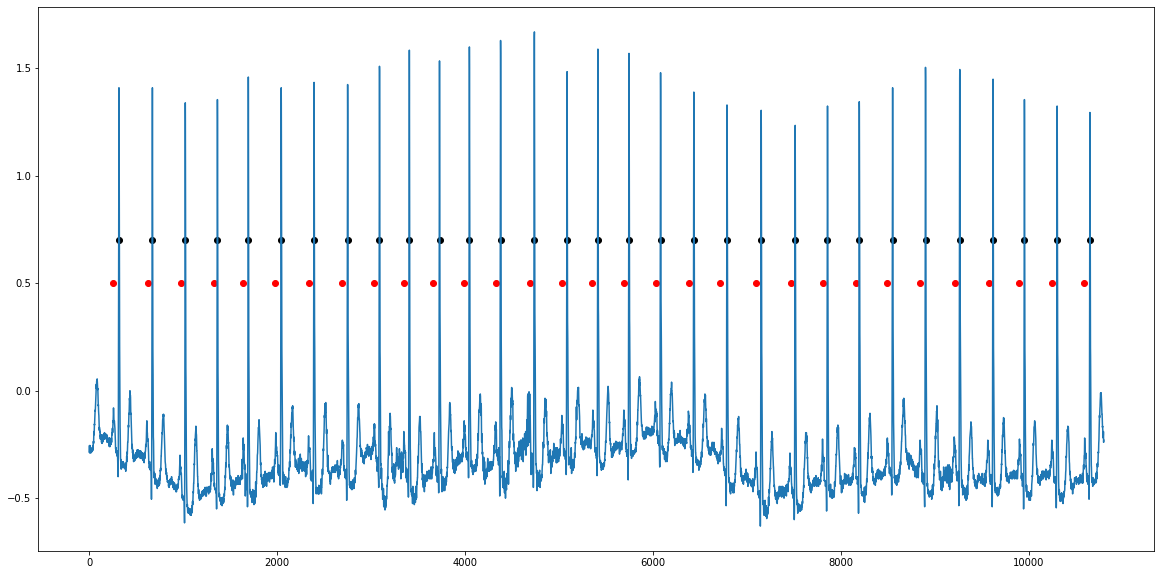

In [56]:
plt.figure(figsize=(20, 10))
plt.plot(tmp.p_signal[:, 0][:360*30])
plt.scatter([x for x in tmpannpwave.sample if x < 360*30], [0.5 for x in tmpannpwave.sample if x < 360*30], c='r')
plt.scatter([x for x in tmpannqrs.sample if x < 360*30], [0.7 for x in tmpannqrs.sample if x < 360*30], c='k')

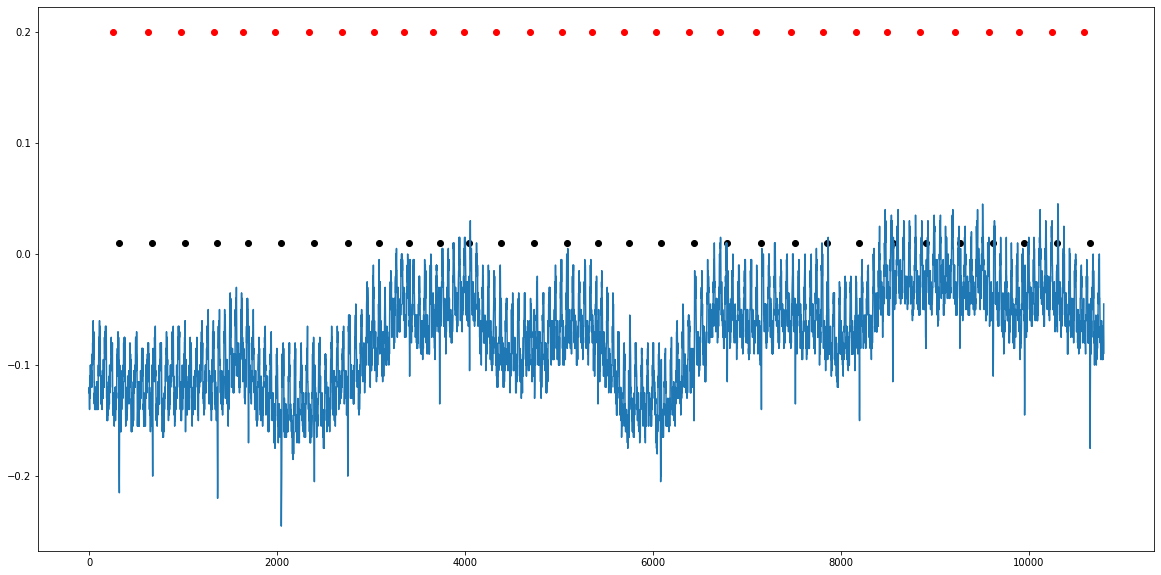

In [59]:
plt.figure(figsize=(20, 10))
plt.plot(tmp.p_signal[:, 1][:360*30])
plt.scatter([x for x in tmpannpwave.sample if x < 360*30], [0.2 for x in tmpannpwave.sample if x < 360*30], c='r')
plt.scatter([x for x in tmpannqrs.sample if x < 360*30], [0.01 for x in tmpannqrs.sample if x < 360*30], c='k')

# MIT-BIH Pwave

In [9]:
pwave_data_path = '/labs/hulab/stark_stuff/physionet.org/files/pwave/1.0.0/'
!ls '/labs/hulab/stark_stuff/physionet.org/files/pwave/1.0.0/'



100.dat    103.hea    117.pwave  207.dat    222.hea    231.pwave
100.hea    103.pwave  119.dat	 207.hea    222.pwave  ANNOTATORS
100.pwave  106.dat    119.hea	 207.pwave  223.dat    index.html
101.dat    106.hea    119.pwave  214.dat    223.hea    RECORDS
101.hea    106.pwave  122.dat	 214.hea    223.pwave  SHA256SUMS.txt
101.pwave  117.dat    122.hea	 214.pwave  231.dat
103.dat    117.hea    122.pwave  222.dat    231.hea


In [8]:
a = '100'
tmp = wfdb.rdrecord(f'{pwave_data_path}/{a}') 
tmpannpwave = wfdb.rdann(f'{pwave_data_path}/{a}', 'pwave') 

display(tmp.__dict__)
display(tmpannpwave.__dict__)


tmp.p_signal.shape

{'record_name': '100',
 'n_sig': 2,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 650000,
 'base_time': None,
 'base_date': None,
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'sig_name': ['MLII', 'V5'],
 'p_signal': array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['100.dat', '100.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [1024, 1024],
 'units': ['mV', 'mV'],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'init_value': [995, 1011],
 'checksum': [-22131, 20052],
 'block_size': [0, 0]}

{'record_name': '100',
 'extension': 'pwave',
 'sample': array([     2,    311,    595, ..., 649430, 649683, 649941]),
 'symbol': ['p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  'p',
  '

(650000, 2)

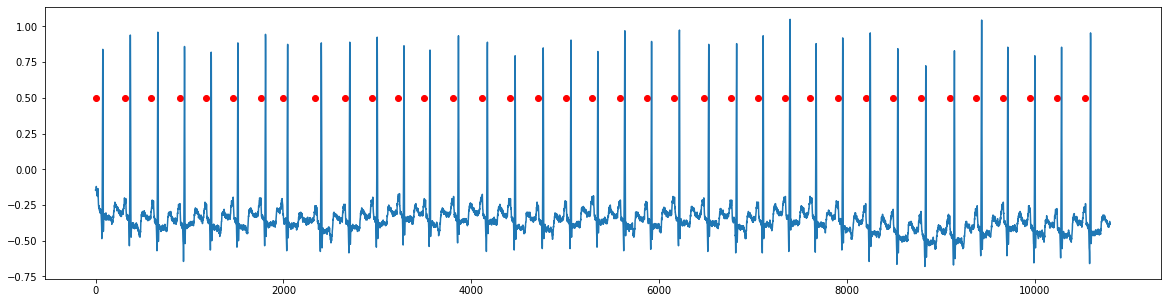

In [23]:
plt.figure(figsize=(20, 5))
plt.plot(tmp.p_signal[:, 0][:360*30])
plt.scatter([x for x in tmpannpwave.sample if x < 360*30], [0.5 for x in tmpannpwave.sample if x < 360*30], c='r')

In [14]:
fname_lst = set()
for f in os.listdir(pwave_data_path):
    if len(f.split('.')[0]) == 3:
        fname_lst.add(f.split('.')[0])
    
fname_lst

{'100',
 '101',
 '103',
 '106',
 '117',
 '119',
 '122',
 '207',
 '214',
 '222',
 '223',
 '231'}

In [20]:
(360*60)*(650000 // (360*60))

648000

In [27]:
fs = 360

all_sigs = []
all_pwave_flags = []


for f in fname_lst:
    record = wfdb.rdrecord(f'{pwave_data_path}/{a}') 
    annpwave = wfdb.rdann(f'{pwave_data_path}/{a}', 'pwave') 
    
    sig = record.p_signal[:, 0][: (360*60)*(650000 // (360*60))]
    pwave_idx = np.asarray([x for x in annpwave.sample if x <= (360*60)*(650000 // (360*60))])
    pwave_flag = np.zeros((sig.shape[0], ))
    pwave_flag[pwave_idx] = 1
    
    splitted_sig = np.array_split(sig, 30)
    splitted_pwave_flag = np.array_split(pwave_flag, 30)
    
    for s in splitted_sig:
        all_sigs.append(s)
        
    for pf in splitted_pwave_flag:
        all_pwave_flags.append(pf)
    
    
all_sigs = np.asarray(all_sigs)
all_pwave_flags = np.asarray(all_pwave_flags)
print(all_sigs.shape, all_pwave_flags.shape)

(360, 21600) (360, 21600)


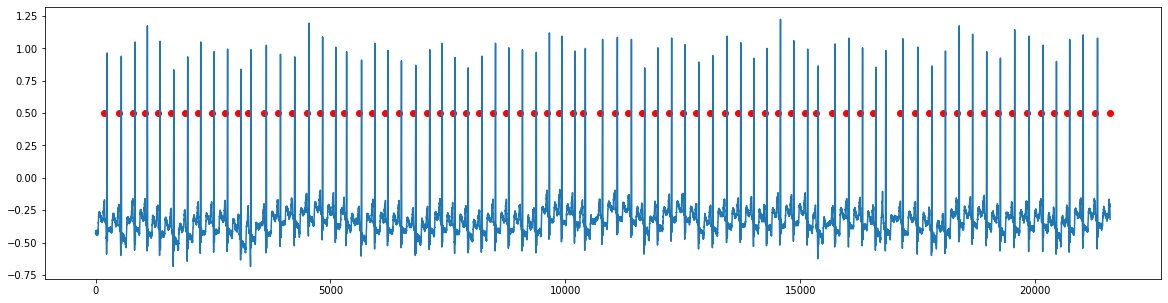

In [28]:
plt.figure(figsize=(20, 5))
plt.plot(all_sigs[44])
plt.scatter(np.where(all_pwave_flags[44]==1)[0], [0.5 for x in np.where(all_pwave_flags[44]==1)[0]], c='r')